# Spectral Bias in Neural Networks (1D Regression)

In this notebook, we study how a neural network learns different frequency components
of a target function during training.
This phenomenon is often referred to as **spectral bias** or **frequency bias**.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Reproducibility
torch.manual_seed(0)
np.random.seed(0)

## 1. Dataset: A multi-frequency 1D signal

We consider a function defined on the interval $[0,1)$ composed of several sine waves
with increasing frequencies:

- Low frequency
- Medium frequency
- High frequency

This allows us to visually track which frequencies are learned first during training.

In [2]:
# Number of sample points
N = 1024

# Input grid
x = np.linspace(0, 1, N, endpoint=False)
x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(1)

# Target function: sum of sinusoids
f_true = (
    1.0 * np.sin(2 * np.pi * x)     # low frequency
  + 0.5 * np.sin(8 * np.pi * x)     # medium frequency
  + 0.2 * np.sin(32 * np.pi * x)    # high frequency
)

y_t = torch.tensor(f_true, dtype=torch.float32).unsqueeze(1)

## 2. Neural network model

We use a small fully connected neural network with:
- Input dimension: 1
- Two hidden layers with Tanh activation
- Output dimension: 1

This architecture is intentionally simple to highlight *learning behavior*
rather than model expressiveness. 

In [3]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = Network()

## 3. Optimization setup

We train the network using:
- Mean Squared Error (MSE) loss
- Adam optimizer with a relatively large learning rate

We record the network output at selected epochs in order to visualize
how the approximation evolves during training.

In [4]:
# We use Adam optimizer implemented in Pytorch, with step size/learning rate set to 1e-2
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# The model is trained in data-driven regime. 
# We aim to minimize missfit between output of the network and the target solution
loss_fn = nn.MSELoss()

# We train for 8000 epochs and record network preditction at specific epochs
epochs = 8000
record_epochs = [100, 1500, 4000, 7500]

outputs = {}

## 4. Training loop

During training, we periodically store the predicted output of the network.
This allows us to inspect which frequency components are captured at different stages.

In [5]:
for ep in range(epochs):
    optimizer.zero_grad()
    pred = model(x_t)
    loss = loss_fn(pred, y_t)
    loss.backward()
    optimizer.step()

    if ep in record_epochs:
        with torch.no_grad():
            y_pred = model(x_t).cpu().numpy().squeeze()
        outputs[ep] = y_pred
        print(f"Epoch {ep:5d} | Loss = {loss.item():.3e}")

Epoch   100 | Loss = 1.284e-01
Epoch  1500 | Loss = 1.698e-02
Epoch  4000 | Loss = 5.658e-03
Epoch  7500 | Loss = 1.592e-03


## 5. Visualization: learning different frequencies

Each subplot shows the network prediction at a different training epoch.
Observe how the low-frequency components are learned first, while
high-frequency oscillations appear much later in training.

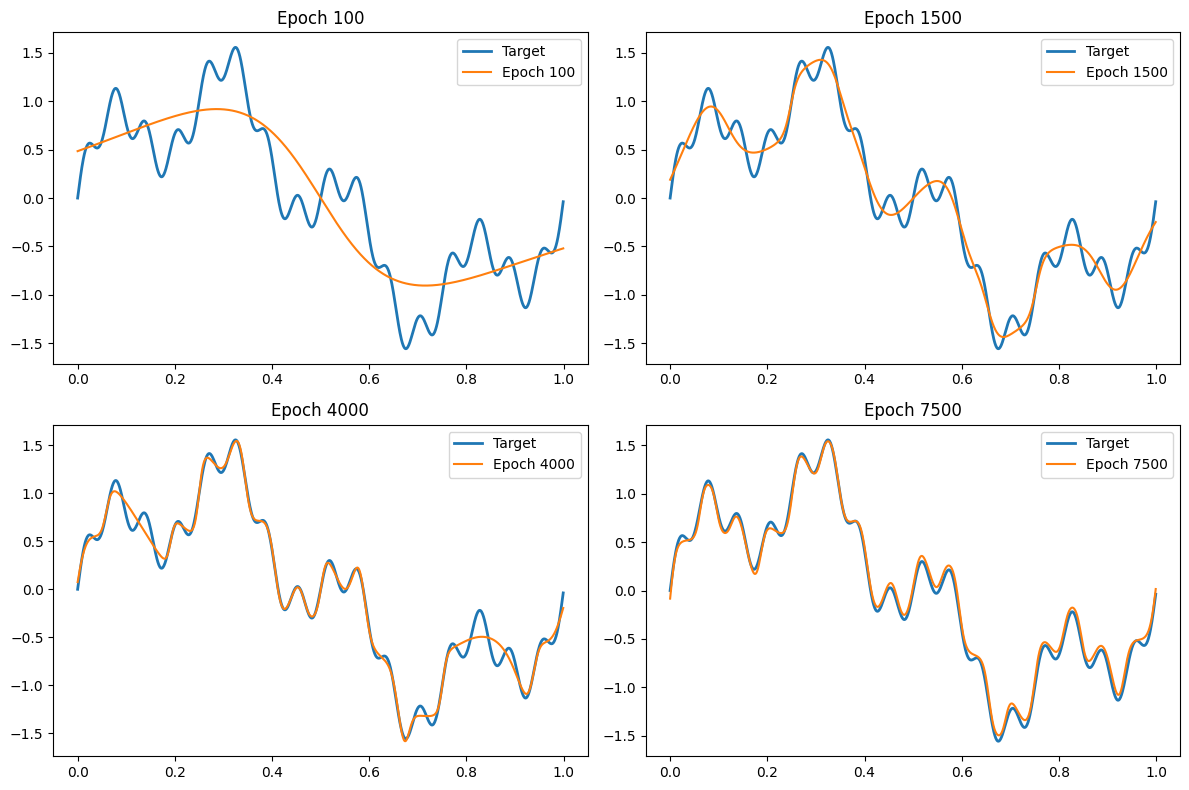

In [7]:
plt.figure(figsize=(12, 8))

for i, ep in enumerate(record_epochs):
    plt.subplot(2, 2, i + 1)
    plt.plot(x, f_true, label="Target", linewidth=2)
    plt.plot(x, outputs[ep], label=f"Epoch {ep}")
    plt.legend()
    plt.title(f"Epoch {ep}")

plt.tight_layout()
plt.show()

## 6. Discussion: Spectral bias

**Key observation:**
- Low-frequency components are learned rapidly
- High-frequency components emerge much later

This behavior is known as **spectral bias**.

### Why does this matter?
- In SciML and PINNs, PDE solutions often contain high-frequency or localized features
- Standard neural networks may struggle to learn these efficiently